In [5]:
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.metrics import f1_score

In [6]:
BERT_BASE_PATH = "D:/bert-base/"
BERT_BASE_TOKENIZER = BERT_BASE_PATH + "tokenizer"
BERT_BASE_MODEL = BERT_BASE_PATH + "bert-base-uncased-fine-tuned"

BERT_LARGE_PATH = "D:/bert-large-uncased/"
BERT_LARGE_TOKENIZER = BERT_LARGE_PATH + "tokenizer"
BERT_LARGE_MODEL = BERT_LARGE_PATH + "bert-large-uncased-fine-tuned"

ROBERTA_BASE_PATH = "D:/roberta-base/"
ROBERTA_BASE_TOKENIZER = ROBERTA_BASE_PATH + "tokenizer"
ROBERTA_BASE_MODEL = ROBERTA_BASE_PATH + "roberta-base-fine-tuned"

ROBERTA_LARGE_PATH = "D:/roberta-large/"
ROBERTA_LARGE_TOKENIZER = ROBERTA_LARGE_PATH + "tokenizer"
ROBERTA_LARGE_MODEL = ROBERTA_LARGE_PATH + "roberta-large-fine-tuned"

DEBERTA_LARGE_PATH = "D:/deberta-large/"
DEBERTA_LARGE_TOKENIZER = DEBERTA_LARGE_PATH + "tokenizer"
DEBERTA_LARGE_MODEL = DEBERTA_LARGE_PATH + "deberta-large-fine-tuned"

DEBERTA_PATH = "D:/deberta-base/"
DEBERTA_TOKENIZER = DEBERTA_PATH + "tokenizer"
DEBERTA_MODEL = DEBERTA_PATH + "deberta-base-fine-tuned"


TARGET_LIST = ['Self-direction: thought', 'Self-direction: action', 'Stimulation', 'Hedonism', 'Achievement', 'Power: dominance', 'Power: resources', 'Face', 'Security: personal', 'Security: societal', 'Tradition', 'Conformity: rules', 'Conformity: interpersonal', 'Humility', 'Benevolence: caring', 'Benevolence: dependability', 'Universalism: concern', 'Universalism: nature', 'Universalism: tolerance']

In [7]:
bert_model = AutoModelForSequenceClassification.from_pretrained(BERT_BASE_MODEL, num_labels = 19)
bert_tokenizer = AutoTokenizer.from_pretrained(BERT_BASE_TOKENIZER)

roberta_model = AutoModelForSequenceClassification.from_pretrained(ROBERTA_BASE_MODEL, return_dict=False, num_labels = 19)
roberta_tokenizer = AutoTokenizer.from_pretrained(ROBERTA_BASE_TOKENIZER)

bert_large_model = AutoModelForSequenceClassification.from_pretrained(BERT_LARGE_MODEL, num_labels = 19)
bert_large_tokenizer = AutoTokenizer.from_pretrained(BERT_LARGE_TOKENIZER)

roberta_large_model = AutoModelForSequenceClassification.from_pretrained(ROBERTA_LARGE_MODEL, return_dict=False, num_labels = 19)
roberta_large_tokenizer = AutoTokenizer.from_pretrained(ROBERTA_LARGE_TOKENIZER)

deberta_model = AutoModelForSequenceClassification.from_pretrained(DEBERTA_MODEL, return_dict=False, num_labels = 19)
deberta_tokenizer = AutoTokenizer.from_pretrained(DEBERTA_TOKENIZER)

deberta_large_model = AutoModelForSequenceClassification.from_pretrained(DEBERTA_LARGE_MODEL, return_dict=False, num_labels = 19)
deberta_large_tokenizer = AutoTokenizer.from_pretrained(DEBERTA_LARGE_TOKENIZER)



In [5]:
import pandas as pd
import ast
val_dataset = pd.read_csv('df_val.csv')
val_dataset['label']

val_dataset['label'] = val_dataset['label'].apply(lambda x: ast.literal_eval(x))

labels = [label for label in TARGET_LIST if label not in ["Text-ID", "Sentence-ID"]]
id2label = {idx:label for idx, label in enumerate(labels)}
label2id = {label:idx for idx, label in enumerate(labels)}

In [18]:
# predict for each row of val_dataset
def evaluate(model, tokenizer, name, pred_dict, pred_list): 
    acertos = 0
    erros = 0
    with torch.no_grad():
        for _ , row in val_dataset.iterrows():
            text = row.text
            true_labels = [id2label[idx] for idx, label in enumerate(row.label) if label == 1.0]
            encoding = tokenizer(text, return_tensors="pt")
            encoding = {k: v.to(model.device) for k,v in encoding.items()}

            outputs = model(**encoding,return_dict=False)
            sigmoid = torch.nn.Sigmoid()
            probs = sigmoid(outputs[0])
            pred_dict[text] = probs.cpu().numpy()
            # val_dataset.loc[idx, name] = probs.cpu().numpy()

            predictions = np.zeros(probs.shape)
            predictions[np.where(probs.cpu() >= 0.5)] = 1
            pred_list.append(predictions[0].tolist())
            #pint(predictions)

            # turn predicted id's into actual label names
            predicted_labels = [id2label[idx] for idx, label in enumerate(predictions[0]) if label == 1.0]
            if predicted_labels == true_labels:
                acertos += 1
            else:
                erros +=1
        print(f"accuracy for {name}: {acertos/(acertos+erros)}")
            
        

In [22]:
bert_base_dict = {}
bert_base_preds = []
evaluate(bert_model, bert_tokenizer, 'bert-uncased', bert_base_dict, bert_base_preds)

bert_large_dict = {}
bert_large_preds = []
evaluate(bert_large_model, bert_large_tokenizer, 'bert-large-uncased', bert_large_dict, bert_large_preds)

roberta_base_dict = {}
roberta_base_preds = []
evaluate(roberta_model, roberta_tokenizer, 'roberta-base', roberta_base_dict, roberta_base_preds)

roberta_large_base_dict = {}
roberta_large_preds = []
evaluate(roberta_large_model, roberta_large_tokenizer, 'roberta-large', roberta_large_base_dict, roberta_large_preds)

deberta_dict = {}
deberta_preds = []
evaluate(deberta_model, deberta_tokenizer, 'deberta-base', deberta_dict, deberta_preds)

deberta_large_dict = {}
deberta_large_preds = []
evaluate(deberta_large_model, deberta_large_tokenizer, 'deberta-large', deberta_large_dict, deberta_large_preds)

true_preds = []
for _ , row in val_dataset.iterrows():
    true_preds.append(row.label)

print('F1 scores')
print(f'f1 score for bert-uncased (weighted): {f1_score(true_preds, bert_base_preds, average="weighted", zero_division=0)}')
print(f'f1 score for bert-large-uncased (weighted): {f1_score(true_preds, bert_large_preds, average="weighted", zero_division=0)}')
print(f'f1 score for roberta-base (weighted): {f1_score(true_preds, roberta_base_preds, average="weighted", zero_division=0)}')
print(f'f1 score for roberta-large (weighted): {f1_score(true_preds, roberta_large_preds, average="weighted", zero_division=0)}')
print(f'f1 score for deberta-base (weighted): {f1_score(true_preds, deberta_preds, average="weighted", zero_division=0)}')
print(f'f1 score for deberta-large (weighted): {f1_score(true_preds, deberta_large_preds, average="weighted", zero_division=0)}')

print(f'f1 score for bert-uncased (macro): {f1_score(true_preds, bert_base_preds, average="macro", zero_division=0)}')
print(f'f1 score for bert-large-uncased (macro): {f1_score(true_preds, bert_large_preds, average="macro", zero_division=0)}')
print(f'f1 score for roberta-base (macro): {f1_score(true_preds, roberta_base_preds, average="macro", zero_division=0)}')
print(f'f1 score for roberta-large (macro): {f1_score(true_preds, roberta_large_preds, average="macro", zero_division=0)}')
print(f'f1 score for deberta-base (macro): {f1_score(true_preds, deberta_preds, average="macro", zero_division=0)}')
print(f'f1 score for deberta-large (macro): {f1_score(true_preds, deberta_large_preds, average="macro", zero_division=0)}')

print(f'f1 score for bert-uncased (micro): {f1_score(true_preds, bert_base_preds, average="micro", zero_division=0)}')
print(f'f1 score for bert-large-uncased (micro): {f1_score(true_preds, bert_large_preds, average="micro", zero_division=0)}')
print(f'f1 score for roberta-base (micro): {f1_score(true_preds, roberta_base_preds, average="micro", zero_division=0)}')
print(f'f1 score for roberta-large (micro): {f1_score(true_preds, roberta_large_preds, average="micro", zero_division=0)}')
print(f'f1 score for deberta-base (micro): {f1_score(true_preds, deberta_preds, average="micro", zero_division=0)}')
print(f'f1 score for deberta-large (micro): {f1_score(true_preds, deberta_large_preds, average="micro", zero_division=0)}')

print(f'f1 score for bert-uncased (None): {f1_score(true_preds, bert_base_preds, average=None, zero_division=0)}')
print(f'f1 score for bert-large-uncased (None): {f1_score(true_preds, bert_large_preds, average=None, zero_division=0)}')
print(f'f1 score for roberta-base (None): {f1_score(true_preds, roberta_base_preds, average=None, zero_division=0)}')
print(f'f1 score for roberta-large (None): {f1_score(true_preds, roberta_large_preds, average=None, zero_division=0)}')
print(f'f1 score for deberta-base (None): {f1_score(true_preds, deberta_preds, average=None, zero_division=0)}')
print(f'f1 score for deberta-large (None): {f1_score(true_preds, deberta_large_preds, average=None, zero_division=0)}')

val_dataset['bert-uncased'] = val_dataset['text'].map(lambda x: list(bert_base_dict[x]))
val_dataset['bert-large'] = val_dataset['text'].map(lambda x: list(bert_large_dict[x]))
val_dataset['roberta-base'] = val_dataset['text'].map(lambda x: list(roberta_base_dict[x]))
val_dataset['roberta-large'] = val_dataset['text'].map(lambda x: list(roberta_large_base_dict[x]))
val_dataset['deberta-base'] = val_dataset['text'].map(lambda x: list(deberta_dict[x]))
val_dataset['deberta-large'] = val_dataset['text'].map(lambda x: list(deberta_large_dict[x]))
val_dataset.to_csv('final_preds.csv')


accuracy for bert-uncased: 0.2
accuracy for bert-large-uncased: 0.2
accuracy for roberta-base: 0.4
accuracy for roberta-large: 0.3
accuracy for deberta-base: 0.2
accuracy for deberta-large: 0.3
F1 scores
f1 score for bert-uncased (weighted): 0.0
f1 score for bert-large-uncased (weighted): 0.0
f1 score for roberta-base (weighted): 0.29166666666666663
f1 score for roberta-large (weighted): 0.26785714285714285
f1 score for deberta-base (weighted): 0.125
f1 score for deberta-large (weighted): 0.41666666666666663
f1 score for bert-uncased (macro): 0.0
f1 score for bert-large-uncased (macro): 0.0
f1 score for roberta-base (macro): 0.07017543859649122
f1 score for roberta-large (macro): 0.06766917293233082
f1 score for deberta-base (macro): 0.013157894736842105
f1 score for deberta-large (macro): 0.12280701754385966
f1 score for bert-uncased (micro): 0.0
f1 score for bert-large-uncased (micro): 0.0
f1 score for roberta-base (micro): 0.3076923076923077
f1 score for roberta-large (micro): 0.285

In [21]:
val_dataset

,label,text,bert-uncased,bert-large,roberta-base,roberta-large,deberta-base,deberta-large
0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Orban: Gradual reopening may begin after Easter,"[[0.071652755, 0.07887801, 0.084096976, 0.0768...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.00019245839, 0.0040197168, 0.000110956404,...","[[1.1804797e-06, 6.164141e-06, 2.4008077e-06, ...","[[9.07579e-05, 0.0066285133, 0.00015047082, 6....","[[0.0007999373, 0.24027099, 9.1206704e-05, 2.7..."
1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","The faster we vaccinate, the sooner the number...","[[0.07119672, 0.07904839, 0.08431759, 0.076338...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.0011271638, 0.004312554, 0.006540513, 0.00...","[[2.9961699e-05, 5.9705682e-05, 6.554347e-05, ...","[[0.0010300099, 0.0012852724, 0.003029263, 0.0...","[[0.0014040632, 0.004767062, 0.0019702963, 0.0..."
2,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",This is why it is important not to be deceived...,"[[0.071488135, 0.07886547, 0.084531106, 0.0761...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.09038271, 0.08172385, 0.0060059894, 0.0041...","[[0.9111741, 3.8685816e-05, 0.00017572196, 2.5...","[[0.04418467, 0.01108762, 0.0022204248, 0.0014...","[[0.6824417, 0.0046311445, 0.0023964767, 0.000..."
3,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",The prime minister said he expects that the nu...,"[[0.07093579, 0.0789194, 0.08483503, 0.0762947...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.00044922635, 0.0012148422, 0.00042612964, ...","[[1.228445e-06, 1.2787475e-05, 1.8845152e-06, ...","[[4.584926e-05, 0.00013759728, 2.4955423e-05, ...","[[8.177291e-05, 0.032326967, 1.2315497e-05, 1...."
4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Asked why reaching 2.5 million jabs was set as...,"[[0.071243055, 0.078879885, 0.08479765, 0.0763...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.00016564284, 0.00030699407, 0.00018465704,...","[[3.6809647e-06, 2.5689347e-05, 1.168725e-05, ...","[[0.000109301385, 0.00025348098, 1.942246e-05,...","[[0.00040244323, 0.023530731, 0.00022441937, 4..."
5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","""It's our moral duty,"" he underlined.","[[0.071303226, 0.07828475, 0.08459474, 0.07638...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.0006357518, 0.006958611, 0.000821753, 0.00...","[[0.00039289426, 0.00021197366, 7.7613266e-05,...","[[0.0057899416, 0.018844055, 0.0014925047, 0.0...","[[0.04016867, 0.033514917, 0.0034115482, 0.000..."
6,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",There is only one remedy that can help us slow...,"[[0.07123655, 0.07929747, 0.08413229, 0.075776...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.002632515, 0.009733282, 0.014061208, 0.002...","[[2.745434e-06, 3.0855914e-05, 5.622031e-06, 1...","[[0.026834, 0.49133468, 0.112746835, 0.0285840...","[[0.0021740824, 0.014703536, 0.0016973206, 0.0..."
7,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...",Many have suffered serious losses and find it ...,"[[0.07132507, 0.07867495, 0.0837071, 0.0764534...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.0061876043, 0.009977007, 0.0076431753, 0.0...","[[3.6512713e-06, 9.4987605e-05, 1.9318386e-05,...","[[0.0015230292, 0.0045514903, 0.0022306778, 0....","[[0.00085497263, 0.0048524207, 0.00078446785, ..."
8,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...","Once we have managed to contain the epidemic, ...","[[0.07130334, 0.07865247, 0.08486475, 0.076117...","[[nan, nan, nan, nan, nan, nan, nan, nan, nan,...","[[0.0024386644, 0.0086709345, 0.0044776355, 0....","[[1.7032398e-05, 0.00059657864, 0.0002462319, ...","[[0.002160325, 0.034670316, 0.07634886, 0.0069...","[[0.022736816, 0.15471722, 0.44300163, 0.00371..."
9,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","""Everyone has lost their serenity, good spirit...","[[0.07126451, 0.07832598, 0.08461701, 0.076297...","[[nan, nan, 

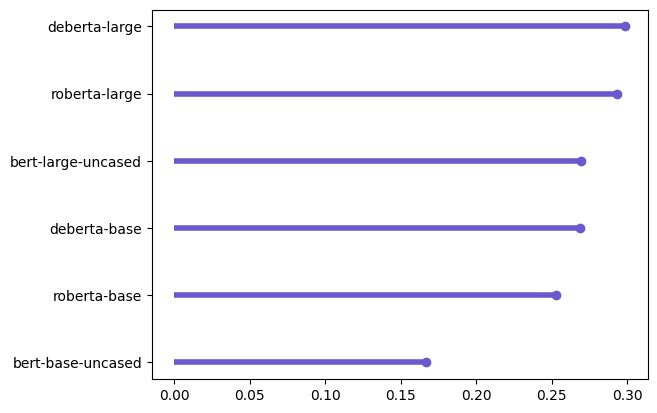

In [4]:
import matplotlib.pyplot as plt
import numpy as np

d = {'bert-base-uncased': 0.16691939082661103, 'bert-large-uncased': 0.2695939816828627, 'roberta-base': 0.25323999340304165, 'roberta-large': 0.29354155627190104, 'deberta-base': 0.26874974711093474, 'deberta-large': 0.2988116271661447}

d = dict(sorted(d.items(), key=lambda item: item[1]))

plt.hlines(y=d.keys(), xmin=0, xmax=d.values(), color='slateblue', linewidth=4)
plt.plot(d.values(), d.keys(), "o", color='slateblue')

plt.show()